# Re-analysis of data from Vogelsang et al., 2024

Here we re-analyse data from Vogelsang et al. (2024), Figure 1. 

The original claim is that visual object recognition performance in Prakash patients is more impaired by removing colour information than are age-matched controls. This claim seemed questionable, given the large performance differences in patients and controls, the ceiling effect evident for controls, and the lacking statistical treatment of these issues. 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pingouin as pg
import plotnine as pn
import patchworklib as pw
from scipy.stats import kurtosis, skew

<Figure size 100x100 with 0 Axes>

In [2]:
cwd = Path.cwd()
top_dir = cwd.parent
df = pd.read_csv(top_dir / "data" / "processed_data" / "experiment1_all_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Group   20 non-null     object
 1   Color   20 non-null     int64 
 2   Gray    20 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 612.0+ bytes


Re-arrange to get ranked proportion data, to enable a non-parametric test:

In [3]:
df["participant_id"] = df.index
df = (
    df.melt(
        id_vars=["Group", "participant_id"],
        var_name="condition",
        value_name="percent_correct",
    )
    .sort_values(by="percent_correct", ascending=False)
    .assign(ranked_performance=lambda x: x["percent_correct"].rank(ascending=True))
    .pivot_table(
        index=["Group", "participant_id"],
        columns=["condition"],
        values=["percent_correct", "ranked_performance"],
    )
    .reset_index()
)
df = df.set_axis(df.columns.map("_".join), axis=1)  # get rid of annoying multiindex
df = df.rename(columns={"Group_": "group", "participant_id_": "participant_id"})
df

,group,participant_id,percent_correct_Color,percent_correct_Gray,ranked_performance_Color,ranked_performance_Gray
0,Control,0,91.0,89.0,28.5,27.0
1,Control,1,97.0,96.0,36.5,35.0
2,Control,2,100.0,95.0,39.5,33.0
3,Control,3,56.0,66.0,13.0,17.0
4,Control,4,95.0,99.0,33.0,38.0
5,Control,5,88.0,81.0,26.0,21.0
6,Control,6,97.0,91.0,36.5,28.5
7,Control,7,100.0,95.0,39.5,33.0
8,Control,8,93.0,84.0,31.0,24.0
9,Control,9,92.0,86.0,30.0,25.0


Create logits from the proportions:

In [4]:
def logit(p):
    p = p / 100
    p[p == 1.0] = 0.99  # need to correct for infinite logits.
    return np.log(p / (1 - p))


df["logit_color"] = logit(df["percent_correct_Color"])
df["logit_gray"] = logit(df["percent_correct_Gray"])
df

,group,participant_id,percent_correct_Color,percent_correct_Gray,ranked_performance_Color,ranked_performance_Gray,logit_color,logit_gray
0,Control,0,91.0,89.0,28.5,27.0,2.313635,2.090741
1,Control,1,97.0,96.0,36.5,35.0,3.476099,3.178054
2,Control,2,100.0,95.0,39.5,33.0,4.595120,2.944439
3,Control,3,56.0,66.0,13.0,17.0,0.241162,0.663294
4,Control,4,95.0,99.0,33.0,38.0,2.944439,4.595120
5,Control,5,88.0,81.0,26.0,21.0,1.992430,1.450010
6,Control,6,97.0,91.0,36.5,28.5,3.476099,2.313635
7,Control,7,100.0,95.0,39.5,33.0,4.595120,2.944439
8,Control,8,93.0,84.0,31.0,24.0,2.586689,1.658228
9,Control,9,92.0,86.0,30.0,25.0,2.442347,1.815290


In [5]:
control_df = df.loc[df["group"] == "Control", :]
prakash_df = df.loc[df["group"] == "Prakash", :]

## 0. Replication of their t-tests on percent correct data

In [6]:
pg.ttest(
    control_df["percent_correct_Color"],
    control_df["percent_correct_Gray"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.478604,9,two-sided,0.17337,"[-1.43, 6.83]",0.237084,0.718,0.103239


In [7]:
pg.ttest(
    prakash_df["percent_correct_Color"],
    prakash_df["percent_correct_Gray"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.782692,9,two-sided,0.000265,"[7.73, 17.67]",0.67787,124.632,0.481722


Vogelsang also do an independent-samples t-test to compare the group means on the difference scores (performance on colour - performance on gray).

In [8]:
pg.ttest(
    prakash_df["percent_correct_Color"] - prakash_df["percent_correct_Gray"],
    control_df["percent_correct_Color"] - control_df["percent_correct_Gray"],
    paired=False,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.501177,18,two-sided,0.00255,"[4.0, 16.0]",1.565774,14.43,0.911352


## 1a. Check t-tests on rank data

In [9]:
pg.ttest(
    control_df["ranked_performance_Color"],
    control_df["ranked_performance_Gray"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.198922,9,two-sided,0.055438,"[-0.09, 6.49]",0.438395,1.631,0.236867


In [10]:
pg.ttest(
    prakash_df["ranked_performance_Color"],
    prakash_df["ranked_performance_Gray"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.596469,9,two-sided,0.001297,"[2.39, 7.01]",0.712931,32.908,0.520844


In [11]:
pg.ttest(
    prakash_df["ranked_performance_Color"] - prakash_df["ranked_performance_Gray"],
    control_df["ranked_performance_Color"] - control_df["ranked_performance_Gray"],
    paired=False,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.843371,18,two-sided,0.410089,"[-2.24, 5.24]",0.377167,0.51,0.125745


The t-test equivalent of the interaction term (comparing difference distributions) provides weak evidence in favour of the null (BF10=0.51).

## 1b. Check t-tests on logit data

In [12]:
pg.ttest(control_df["logit_color"], control_df["logit_gray"], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.59477,9,two-sided,0.145228,"[-0.21, 1.21]",0.41794,0.81,0.219626


In [13]:
pg.ttest(prakash_df["logit_color"], prakash_df["logit_gray"], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.760348,9,two-sided,0.000273,"[0.37, 0.84]",0.704887,121.706,0.511875


Result: the significance tests on logits have the same qualitative conclusion as on percent corrects, but the nonparametric (rank-order) t-tests are borderline (for the control group the colour difference comes close to significance: t(9) = 2.199, p = 0.055, BF10 = 1.63).

In [14]:
pg.ttest(
    prakash_df["logit_color"] - prakash_df["logit_gray"],
    control_df["logit_color"] - control_df["logit_gray"],
    paired=False,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.317321,18,two-sided,0.754651,"[-0.59, 0.8]",0.14191,0.412,0.060425


The t-test equivalent of the interaction term (comparing difference distributions) provides weak evidence in favour of the null (BF10=0.412).

## 2. 2x2 mixed ANOVA

The more common way to analyse this 2x2 design is a mixed-ANOVA (one within-subjects factor and one between-subjects factor).
This yields equivalent results to the combination of paired t-tests and independent t-tests.


### ANOVA with percent correct data

In [15]:
df_long = df[
    ["group", "participant_id", "percent_correct_Color", "percent_correct_Gray"]
].melt(
    id_vars=["group", "participant_id"],
    var_name="img_type",
    value_name="proportion_correct",
)
# df_long
df_long.mixed_anova(
    dv="proportion_correct",
    within="img_type",
    between="group",
    subject="participant_id",
)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,14592.4,1,18,14592.4,31.701551,0.000024,0.637838,NaN
1,img_type,592.9,1,18,592.9,29.071643,0.000040,0.617604,1.0
2,Interaction,250.0,1,18,250.0,12.258240,0.002550,0.405121,NaN


According to a more correct statistical model on raw percentages, the authors' claim is supported.
The interaction is significant (F(1, 18) = 12.26, p = 0.00256).

However, we also know that a linear Gaussian error model is not appropriate for proportion data, particularly when data is near ceiling or floor. We repeat this model with two alternatives: a nonparametric analysis using ranks, and an analysis of the logits.

### ANOVA with rank data

In [16]:
df_long = df[
    ["group", "participant_id", "ranked_performance_Color", "ranked_performance_Gray"]
].melt(
    id_vars=["group", "participant_id"],
    var_name="img_type",
    value_name="rank_performance",
)
# df_long
df_long.mixed_anova(
    dv="rank_performance",
    within="img_type",
    between="group",
    subject="participant_id",
)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,3422.500,1,18,3422.500,38.527205,0.000007,0.681569,NaN
1,img_type,156.025,1,18,156.025,19.729189,0.000315,0.522916,1.0
2,Interaction,5.625,1,18,5.625,0.711275,0.410089,0.038013,NaN


Here, the interaction effect is no longer significant.

### ANOVA with logits

In [17]:
df_long = df[["group", "participant_id", "logit_color", "logit_gray"]].melt(
    id_vars=["group", "participant_id"],
    var_name="img_type",
    value_name="rank_performance",
)
# df_long
df_long.mixed_anova(
    dv="rank_performance",
    within="img_type",
    between="group",
    subject="participant_id",
)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,65.588340,1,18,65.588340,34.485648,0.000015,0.657049,NaN
1,img_type,3.064208,1,18,3.064208,11.167066,0.003631,0.382866,1.0
2,Interaction,0.027630,1,18,0.027630,0.100692,0.754651,0.005563,NaN


Again, the interaction effect required to support the authors' claim is no longer significant.

## Plotting the distributions against each other

In [18]:
plot_dfs = []
plot_dfs.append(
    df[
        ["group", "participant_id", "percent_correct_Color", "percent_correct_Gray"]
    ].melt(id_vars=["group", "participant_id"], value_name="dv", var_name="condition")
)
plot_dfs[0]["condition"] = pd.Categorical(plot_dfs[0]["condition"]).rename_categories(
    {"percent_correct_Color": "Color", "percent_correct_Gray": "Gray"}
)

plot_dfs.append(
    df[
        [
            "group",
            "participant_id",
            "ranked_performance_Color",
            "ranked_performance_Gray",
        ]
    ].melt(id_vars=["group", "participant_id"], value_name="dv", var_name="condition")
)
plot_dfs[1]["condition"] = pd.Categorical(plot_dfs[1]["condition"]).rename_categories(
    {"ranked_performance_Color": "Color", "ranked_performance_Gray": "Gray"}
)

plot_dfs.append(
    df[["group", "participant_id", "logit_color", "logit_gray"]].melt(
        id_vars=["group", "participant_id"], value_name="dv", var_name="condition"
    )
)

plot_dfs[2]["condition"] = pd.Categorical(plot_dfs[2]["condition"]).rename_categories(
    {"logit_color": "Color", "logit_gray": "Gray"}
)

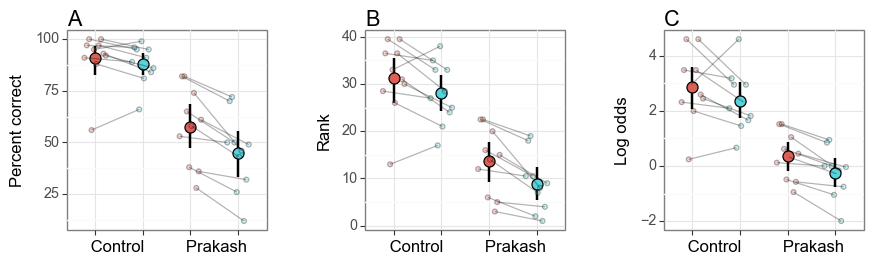

In [19]:
# Add a new column to each DataFrame that combines 'group' and 'condition'
unique_df = df

for unique_df in plot_dfs:
    unique_df["group_condition"] = unique_df["group"].astype(str) + unique_df[
        "condition"
    ].astype(str)

# names for y-axis plots
axis_name = ["Percent correct", "Rank", "Log odds"]

dodge_width = 0.5
base_size = 13
fig_size = (2, 2)
alpha_point = 0.3  # alpha for individual data

### Percent correct
p1 = (
    pn.ggplot(
        data=plot_dfs[0],
        mapping=pn.aes(
            x="group_condition",  # Use the new combined column
            y="dv",
            fill="condition",
            group="participant_id",
        ),
    )
    + pn.stat_summary(
        position=pn.position_dodge(width=dodge_width),
        size=1.0,
        alpha=1.0,
        mapping=pn.aes(group="group_condition"),
    )
    + pn.geom_point(
        position=pn.position_dodge(width=dodge_width),
        alpha=alpha_point,
    )
    + pn.geom_line(
        position=pn.position_dodge(width=dodge_width),
        alpha=alpha_point,
    )
    + pn.theme_bw(base_size=base_size)
    + pn.theme(axis_text_x=pn.element_blank())  # Remove x-axis labels
    + pn.labs(x=" Control         Prakash", fill="", y=axis_name[0], title="A")
    + pn.scale_fill_discrete(guide=False)
)
p1 = pw.load_ggplot(p1, figsize=fig_size)

### Ranks
p2 = (
    pn.ggplot(
        data=plot_dfs[1],
        mapping=pn.aes(
            x="group_condition", y="dv", fill="condition", group="participant_id"
        ),
    )
    + pn.stat_summary(
        position=pn.position_dodge(width=dodge_width),
        size=1.0,
        alpha=1.0,
        mapping=pn.aes(group="group_condition"),
    )
    + pn.geom_point(
        position=pn.position_dodge(width=dodge_width),
        alpha=alpha_point,
    )
    + pn.geom_line(
        position=pn.position_dodge(width=dodge_width),
        alpha=alpha_point,
    )
    + pn.theme_bw(base_size=base_size)
    + pn.theme(
        axis_text_x=pn.element_blank(),
        plot_margin={
            "left": 1000,
            "right": 20,
            "top": 20,
            "bottom": 20,
        },  # Add space on the left and right
    )
    + pn.theme(axis_text_x=pn.element_blank())
    + pn.labs(x=" Control         Prakash", fill="", y=axis_name[1], title="B")
    + pn.scale_fill_discrete(guide=False)
)
p2 = pw.load_ggplot(p2, figsize=fig_size)

### Log odds
p3 = (
    pn.ggplot(
        data=plot_dfs[2],
        mapping=pn.aes(
            x="group_condition", y="dv", fill="condition", group="participant_id"
        ),
    )
    + pn.geom_point(
        position=pn.position_dodge(width=dodge_width),
        alpha=alpha_point,
    )
    + pn.stat_summary(
        position=pn.position_dodge(width=dodge_width),
        size=1.0,
        alpha=1.0,
        mapping=pn.aes(group="group_condition"),
    )
    + pn.geom_line(
        position=pn.position_dodge(width=dodge_width),
        alpha=alpha_point,
    )
    + pn.theme_bw(base_size=base_size)
    + pn.theme(
        axis_text_x=pn.element_blank(),
    )
    + pn.labs(x=" Control         Prakash", fill="", y=axis_name[2], title="C")
    + pn.scale_fill_discrete(guide=False)
    + pn.scale_y_continuous(breaks=np.arange(start=-2, stop=6, step=2))
)
p3 = pw.load_ggplot(p3, figsize=fig_size)

(p1 | p2 | p3).savefig(top_dir / "figures" / "fig_1_raw.pdf")

Calculate Changes in Kurtosis and Skewness

In [20]:
# Function to compute kurtosis and skewness with specified parameters
def compute_kurtosis(series):
    return kurtosis(series, fisher=True, bias=False)


def compute_skew(series):
    return skew(series)


# Calculating kurtosis and skewness for each combination of 'group' and 'condition' for specific columns
grouped_metrics = df.groupby("group").agg(
    {
        "percent_correct_Color": [compute_kurtosis, compute_skew],
        "percent_correct_Gray": [compute_kurtosis, compute_skew],
        "ranked_performance_Color": [compute_kurtosis, compute_skew],
        "ranked_performance_Gray": [compute_kurtosis, compute_skew],
        "logit_color": [compute_kurtosis, compute_skew],
        "logit_gray": [compute_kurtosis, compute_skew],
    }
)

# Printing the results in a formatted table
print(grouped_metrics)

        percent_correct_Color              percent_correct_Gray               \
             compute_kurtosis compute_skew     compute_kurtosis compute_skew   
group                                                                          
Control              7.626056    -2.228817             2.275790    -1.159159   
Prakash             -1.169879    -0.180815            -0.011398    -0.176581   

        ranked_performance_Color              ranked_performance_Gray  \
                compute_kurtosis compute_skew        compute_kurtosis   
group                                                                   
Control                 2.579828    -1.179740               -0.805930   
Prakash                -1.275875    -0.190133               -0.400448   

                          logit_color                    logit_gray  \
        compute_skew compute_kurtosis compute_skew compute_kurtosis   
group                                                                 
Control    -0.141241

## Export processed data

Export the processed data for analysis checks in other packages.

In [21]:
df.to_csv(top_dir / "data" / "processed_data" / "additional_measures.csv", index=False)

See analysis in `scripts/scripts/mixed_effects_logistic_regression.Rmd` for mixed effects logistic regression analysis.